In [104]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

### **Simple Graph**

In [6]:
class AgentState(TypedDict):
    """
    Our state schema
    """
    message: str

def greeting_node(state:AgentState) -> AgentState:
    """
    Simple node that adds greeting message to the state
    """
    state["message"] = "Hey "+ state["message"] + " how is your day going?"
    return state

In [7]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")
app = graph.compile()

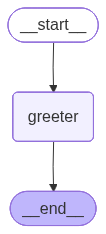

In [8]:
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
result = app.invoke({"message":"Bob"})
result["message"]

'Hey Bob how is your day going?'

In [10]:
def complimentor(state:AgentState) -> AgentState:
    """
    Simple node to compliment the object in the state["message"]
    """
    state["message"] = state["message"] + " you are doing a good job"
    return state

graph_1 = StateGraph(AgentState)

graph_1.add_node("complimentor", complimentor)
graph_1.set_entry_point("complimentor")
graph_1.set_finish_point("complimentor")

app_1 = graph_1.compile()

In [11]:
result = app_1.invoke({"message":"Bob"})
result["message"]

'Bob you are doing a good job'


### **Multi Imput Graphs**


In [13]:
class AgentState(TypedDict):
    values: List[int]
    name: str
    results: str

In [28]:
def process_values(state:AgentState) -> AgentState:
    """
    This handles multiple different input
    """
    state["results"] = f"Hi there {state["name"]}! your sum = {sum(state["values"])}"
    return state

In [29]:
g_3 = StateGraph(AgentState)
g_3.add_node("Processor",process_values)
g_3.set_entry_point("Processor")
g_3.set_finish_point("Processor")
a_3 = g_3.compile()

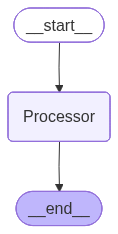

In [30]:
display(Image(a_3.get_graph().draw_mermaid_png()))

In [32]:
r_3 = a_3.invoke({"name":"flashy","values":[1,2,3,4,5,6]})
r_3

{'values': [1, 2, 3, 4, 5, 6],
 'name': 'flashy',
 'results': 'Hi there flashy! your sum = 21'}

### **Multi Node Graph**

In [34]:
class AgentState(TypedDict):
    name: str
    age: str
    final: str

In [41]:
def first(state: AgentState) -> AgentState:
    """
    First node of the sequence
    """
    state["final"] = f"Hi {state["name"]}"
    return state

def second(state: AgentState) -> AgentState:
    """
    Second node of the sequence
    """
    state["final"] += f" you are {state["age"]} years old!"
    return state

In [42]:
g_4 = StateGraph(AgentState)
g_4.add_node("namer",first)
g_4.add_node("age teller",second)
g_4.set_entry_point("namer")
g_4.add_edge("namer","age teller") # Directed edge
g_4.set_finish_point("age teller")
a_4 = g_4.compile()

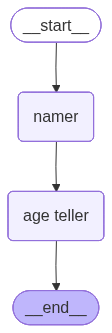

In [43]:
display(Image(a_4.get_graph().draw_mermaid_png()))

In [44]:
r_4 = a_4.invoke({"name": "John","age":"32"})
r_4

{'name': 'John', 'age': '32', 'final': 'Hi John you are 32 years old!'}

### **Conditional Node**

In [47]:
class AgentState(TypedDict):
    num_1: int
    num_2: int
    operation: str
    final_num: int

In [56]:
def adder(state: AgentState) -> AgentState:
    """
    This node adds the two numbers
    """
    state["final_num"] = state["num_1"] + state["num_2"]
    return state 

def sub(state: AgentState) -> AgentState:
    """
    This node subtracts the two numbers"
    """
    state["final_num"] = state["num_1"] - state["num_2"]
    return state

def decide_next_node(state: AgentState) -> AgentState:
    """
    This will decide the next node of graph
    """
    if state["operation"] == "+":
        return "addition_operation"
    elif state["operation"] == "-":
        return "sub_operation"

In [57]:
g_5 = StateGraph(AgentState)

g_5.add_node("router", lambda state:state) # In the lambda function it is saying that the input state is the output state(passthrough funtion)
g_5.add_node("adder",adder)
g_5.add_node("subtractor",sub)

g_5.add_edge(START, "router")
g_5.add_conditional_edges(
        source= "router",
        path= decide_next_node,
        path_map= {
                    # Edge : Node
                    "addition_operation": "adder",
                    "sub_operation" : "subtractor"
                } 
        )

g_5.add_edge("adder",END)
g_5.add_edge("subtractor",END)

a_5 = g_5.compile()

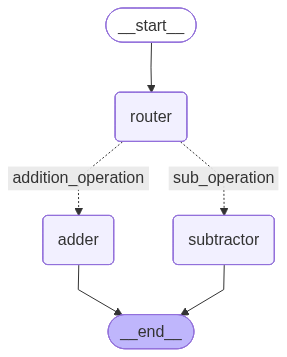

In [58]:
display(Image(a_5.get_graph().draw_mermaid_png()))

In [59]:
intitial_state = AgentState(num_1=10,num_2=5,operation="-")
r_5 = a_5.invoke(intitial_state)
r_5

{'num_1': 10, 'num_2': 5, 'operation': '-', 'final_num': 5}

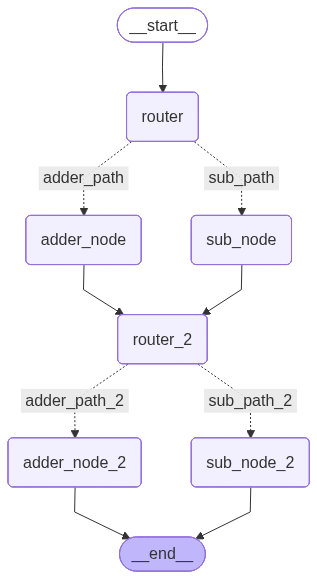

In [90]:
class AgentState(TypedDict):
    num_1: int
    num_2: int
    num_3: int
    num_4: int
    op_1: str
    op_2: str
    res_1: int
    res_2: int
    it: int

def adder_1(state: AgentState) -> AgentState:
    """
    This node adds the two numbers
    """
    if not state["it"]:
        state["res_1"] = state["num_1"] + state["num_2"]
        state["it"] += 1
    else:
        state["res_2"] = state["num_3"] + state["num_4"]
    
    return state 

def sub_1(state: AgentState) -> AgentState:
    """
    This node adds the two numbers
    """
    if not state["it"]:
        state["res_1"] = state["num_1"] - state["num_2"]
        state["it"] += 1
    else:
        state["res_2"] = state["num_3"] - state["num_4"]
    
    return state 

def decide_next_node(state: AgentState) -> AgentState: # Returns edge names
    if not state["it"]:
        if state["op_1"] == "+":
            return "adder_path"
        elif state["op_1"] == "-":
            return "sub_path" 
    else:
        if state["op_2"] == "+":
            return "adder_path_2"
        elif state["op_2"] == "-":
            return "sub_path_2"

g_6 = StateGraph(AgentState)

g_6.add_node("adder_node",adder_1)
g_6.add_node("sub_node",sub_1)
g_6.add_node("router",lambda state:state)
g_6.add_node("adder_node_2",adder_1)
g_6.add_node("sub_node_2",sub_1)
g_6.add_node("router_2",lambda state:state)

g_6.add_edge(START,"router")
g_6.add_conditional_edges(source="router",
                          path=decide_next_node,
                          path_map={"adder_path":"adder_node","sub_path":"sub_node"}
                        )
g_6.add_edge("adder_node","router_2")
g_6.add_edge("sub_node","router_2")
g_6.add_conditional_edges(source="router_2",
                          path=decide_next_node,
                          path_map={"adder_path_2":"adder_node_2","sub_path_2":"sub_node_2"}
                        )
g_6.add_edge("adder_node_2",END)
g_6.add_edge("sub_node_2",END)

a_6 = g_6.compile()
display(Image(a_6.get_graph().draw_mermaid_png()))

In [92]:
intitial_state = AgentState(num_1=25,num_2=5,num_3 = 22,num_4 = 8,op_1="-",op_2 = "+",it = 0)
a_6.invoke(intitial_state)

{'num_1': 25,
 'num_2': 5,
 'num_3': 22,
 'num_4': 8,
 'op_1': '-',
 'op_2': '+',
 'res_1': 20,
 'res_2': 30,
 'it': 1}

### **Looping Graph**

In [99]:
class AgentState(TypedDict):
    name: str
    numbers: List[int]
    counter: int    

In [100]:
def greeting_node(state:AgentState) -> AgentState:
    """
    Simple node that adds greeting message to the state
    """
    state["message"] = "Hey "+ state["name"] + " how is your day going?"
    state["counter"] = 0
    return state

def random_node(state:AgentState) -> AgentState:
    """Generates random number b/w 1 to 10"""
    state["numbers"].append(random.randint(0,10))
    state["counter"]+=1
    return state

def should_continue(state:AgentState) -> AgentState:
    """Function to decide if the loop should continue"""
    if state["counter"] < 5:
        print("Entering Loop",state["counter"])
        return "loop"
    else:
        return "exit"

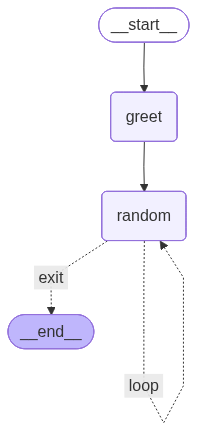

In [101]:
g_7 = StateGraph(AgentState)

g_7.add_node("greet",greeting_node)
g_7.add_node("random",random_node)

g_7.add_edge(START,"greet")
g_7.add_edge("greet","random")
g_7.add_conditional_edges(source="random",
                          path= should_continue,
                          path_map={"exit":END,"loop":"random"}
                          )

a_7 = g_7.compile()

display(Image(a_7.get_graph().draw_mermaid_png()))

In [103]:
state_1 = {"name" : "joe","numbers":[]}
a_7.invoke(state_1)

Entering Loop 1
Entering Loop 2
Entering Loop 3
Entering Loop 4


{'name': 'joe', 'numbers': [0, 6, 7, 6, 1], 'counter': 5}

### **Number Guessing Game**

In [88]:
class AgentState(TypedDict):
    name: str
    num: int
    guess: List[int]
    up: int
    low: int
    attempts: int

In [89]:
def setup(state: AgentState) -> AgentState:
    """Seting up the initial config"""
    print(f"Let the game begin {state['name']} !!!")
    state['num'] = random.randint(state['low'],state['up'])
    state['guess'] = []
    return state

def guess(state: AgentState) -> AgentState:
    """Guesses the number"""
    state['guess'].append(random.randint(state['low'],state['up']))
    print(f"{len(state['guess'])} ,  iteration and bounds are {state['low']} to {state['up']} and current guess is {state['guess'][-1]}")
    return state

def check(state:AgentState) -> str:
    # If Equal then win condition
    if state['guess'][-1] == state['num']:
        return "win"
    # If not equal and attempts left then try again condition
    elif state['guess'][-1] != state['num'] and len(state['guess'] ) < state['attempts']:
        if state['guess'][-1] > state['num']:
            state['up'] = state['guess'][-1] - 1
        else:
            state['low'] = state['guess'][-1] + 1
        return "try_again"
    # Loose Condition
    else:
        return "lost"

def update_bounds(state: AgentState) -> AgentState:
    last_guess = state['guess'][-1]
    target = state['num']

    if last_guess > target:
        state['up'] = last_guess - 1
    elif last_guess < target:
        state['low'] = last_guess + 1

    return state
    
def win_node(state:AgentState) -> AgentState:
    print(f"Congrats {state['name']}, you won")
    return state

def lose_node(state:AgentState) -> AgentState:
    print(f"Sad {state['name']}, you loose lil bro")
    return state

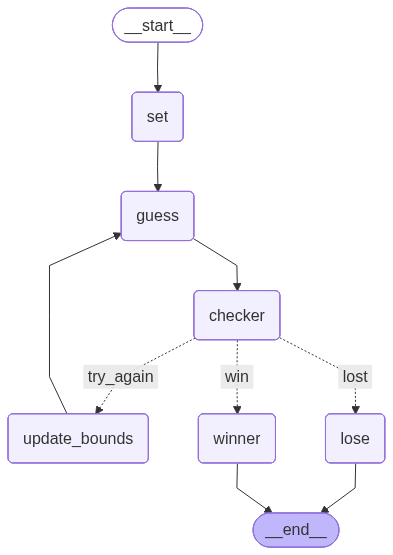

In [91]:
g_8 = StateGraph(AgentState)

g_8.add_node("set",setup)
g_8.add_node("guess",guess)
g_8.add_node("checker",lambda state:state)
g_8.add_node("update_bounds",update_bounds)
g_8.add_node("winner",win_node)
g_8.add_node("lose",lose_node)

g_8.add_edge(START,"set")
g_8.add_edge("set","guess")
g_8.add_edge("guess","checker")
g_8.add_conditional_edges(source="checker",
                          path=check,
                          path_map={
                              "win": "winner",
                              "try_again": "update_bounds",
                              "lost" : "lose"
                          })
g_8.add_edge("update_bounds","guess")
g_8.add_edge("winner",END)
g_8.add_edge("lose",END)

a_8 = g_8.compile()

display(Image(a_8.get_graph().draw_mermaid_png()))

In [99]:
state_1 = {
    "name": "Hugh",
    "num": 4,
    "guess": [],
    "up": 100,
    "low": 0,
    "attempts": 5
}

a_8.invoke(state_1)

Let the game begin Hugh !!!
1 ,  iteration and bounds are 0 to 100 and current guess is 39
2 ,  iteration and bounds are 40 to 100 and current guess is 85
3 ,  iteration and bounds are 40 to 84 and current guess is 69
4 ,  iteration and bounds are 70 to 84 and current guess is 75
5 ,  iteration and bounds are 76 to 84 and current guess is 83
Sad Hugh, you loose lil bro


{'name': 'Hugh',
 'num': 80,
 'guess': [39, 85, 69, 75, 83],
 'up': 84,
 'low': 76,
 'attempts': 5}

In [ ]:
load_docenv()

class AgentState(TypedDict):
    messages: List[HumanMessage]